env `snomed`

In [1]:
import sys
import os
import seaborn as sns
import subprocess


In [2]:
# !conda install --yes --prefix {sys.prefix} spacy

In [3]:

DATA_DIR = "/data/karen"

if not os.path.exists(f"{DATA_DIR}/pym.sqlite3"):
    from owlready2 import *
    from owlready2.pymedtermino2 import *
    from owlready2.pymedtermino2.umls import *
    default_world.set_backend(filename = f"{DATA_DIR}/pym.sqlite3")
    import_umls(f"{DATA_DIR}/umls-2022AA-full.zip", terminologies = ["SNOMEDCT_US", "CUI"])
    default_world.save()
else:
    from owlready2.pymedtermino2 import umls
    try:
        umls.default_world.set_backend(filename = f"{DATA_DIR}/pym.sqlite3")
    except:
        print("File locked. Run script to release lock. Restart notebook if it doesn't work.")
        p = subprocess.run(["bash", "remove_sql_lock.sh"])
        umls.default_world.set_backend(filename = f"{DATA_DIR}/pym.sqlite3")
    # do not import following lib before above steps
    from owlready2 import *
    from owlready2.pymedtermino2.model import Concepts

In [4]:
PYM = get_ontology("http://PYM/").load()
SNOMEDCT_US = PYM["SNOMEDCT_US"]
CUI = PYM["CUI"]

In [5]:
import seaborn as sns

def sort_two_lists(list1, list2):
    zipped_lists = zip(list1, list2)
    sorted_pairs = sorted(zipped_lists, key=lambda pair: pair[1])

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    return list1, list2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.2 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.6.1 which is incompatible.
medspacy 1.1.5 requires spacy<3.6,>=3.4.1, but you have spacy 3.6.1 which is incompatible.
Successfully installed en-core-sci-sm-0.5.3 spacy-3.6.1

In [6]:
import spacy
# from medspacy.context import ConTextComponent
from medspacy.visualization import visualize_ent
from scispacy.linking import EntityLinker
nlp = spacy.load("en_core_sci_sm")
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})
nlp.add_pipe("medspacy_context")

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmp8z2inz38
Finished download, copying /tmp/tmp8z2inz38 to cache at /home/karenzhou/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmpv9n970qi
Finished download, copying /tmp/tmpv9n970qi to cache at /home/karenzhou/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpqo38uwh9
Finished download, copying /tmp/tmpqo38uwh9 to cache a

In [7]:
def sort_two_lists(list1, list2):
    if len(list1) == 0:
        return [], []
    zipped_lists = zip(list1, list2)
    sorted_pairs = sorted(zipped_lists, key=lambda pair: pair[1])

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    return list1, list2

def get_snomed_concepts(text, visulization=False, remove_negated_entity=True):
    doc = nlp(text)
    if visulization:
        visualize_ent(doc)
    umls_concepts = Concepts()

    # Each entity is linked to UMLS with a score
    # (currently just char-3gram matching).
    # linker = nlp.get_pipe("scispacy_linker")
    for entity in doc.ents:
        if remove_negated_entity and entity._.is_negated:
            continue
        for umls_ent in entity._.kb_ents:
#             print(linker.kb.cui_to_entity[umls_ent[0]])
#             print(umls_ent[0])
            if CUI[umls_ent[0]] and CUI[umls_ent[0]].name:
                umls_concepts.add(CUI[umls_ent[0]])
                break
#     print(umls_concepts)
    snomed_concepts = umls_concepts >> SNOMEDCT_US
#     print(snomed_concepts)
    return snomed_concepts

def get_children_concept_distribution(snomed_concepts, root_name, visulization=False):
    #     level_1 = SNOMEDCT_US["138875005"].children # root
    #     level_1 = SNOMEDCT_US["404684003"].children # clinical findings
    #     level_1 = SNOMEDCT_US["48176007"].children # Social context
    level_1 = SNOMEDCT_US[root_name].children
    count_dic = {}
    for s_c in list(snomed_concepts):
        while s_c.parents:
            s_c = s_c.parents[0]
            if s_c in level_1:
                count_dic[s_c.name] = count_dic.get(s_c.name, 0) + 1
                break
#     print(count_dic)
    s_names, counts = sort_two_lists(list(count_dic.keys()), list(count_dic.values()))
    s_labels = [str(SNOMEDCT_US[s_name].label[0]) for s_name in s_names]
    # print(s_labels, counts)
    if s_names and visulization:
        sns.barplot(y=s_labels, x=counts)
    return {name : c for name, c in zip(s_labels, counts)}

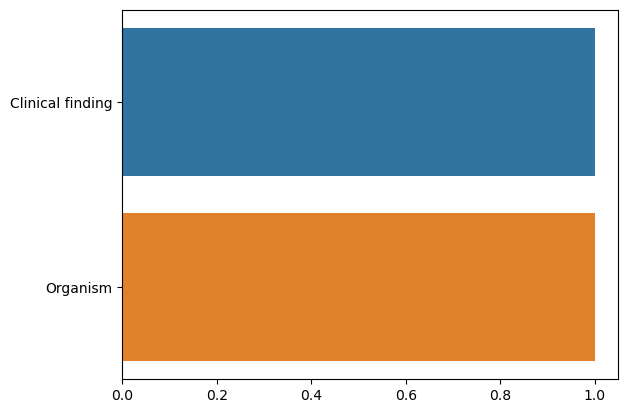

In [18]:
text = "Alterations in the hypocretin receptor 2 and preprohypocretin genes produce narcolepsy in some animals."
concepts = get_snomed_concepts(text, visulization=True)
snomed_concept_list = [[c.name, c.label.first()] for c in concepts]
#     level_1 = SNOMEDCT_US["138875005"].children # root
#     level_1 = SNOMEDCT_US["404684003"].children # clinical findings
#     level_1 = SNOMEDCT_US["48176007"].children # Social context
cell_dict = {}
cell_dict["concepts"] = snomed_concept_list
# get root children distribution
cell_dict["root"] = get_children_concept_distribution(concepts, "138875005", visulization=True)
# get next level children distribution
for child in SNOMEDCT_US["138875005"].children:
    cell_dict[child.label.first()] = get_children_concept_distribution(concepts, child.name)
# text = "Alterations in the hypocretin receptor 2 and preprohypocretin genes produce narcolepsy in some animals."

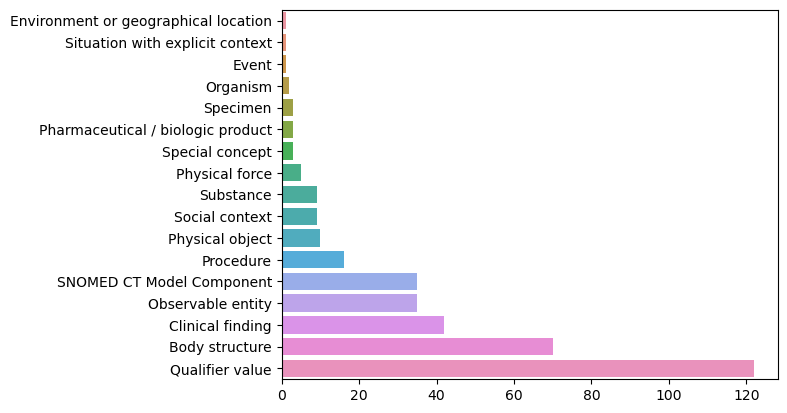

In [10]:

with open("example_article1.txt") as f:
    text = f.read()
concepts = get_snomed_concepts(text, visulization=True)
snomed_concept_list = [[c.name, c.label.first()] for c in concepts]
#     level_1 = SNOMEDCT_US["138875005"].children # root
#     level_1 = SNOMEDCT_US["404684003"].children # clinical findings
#     level_1 = SNOMEDCT_US["48176007"].children # Social context
cell_dict = {}
cell_dict["concepts"] = snomed_concept_list
# get root children distribution
cell_dict["root"] = get_children_concept_distribution(concepts, "138875005", visulization=True)
# get next level children distribution
for child in SNOMEDCT_US["138875005"].children:
    cell_dict[child.label.first()] = get_children_concept_distribution(concepts, child.name)
# text = "Alterations in the hypocretin receptor 2 and preprohypocretin genes produce narcolepsy in some animals."

In [11]:
with open("example_article2.txt") as f:
    text = f.read()

In [12]:
# Print children of root
SNOMEDCT_US["138875005"].children

[SNOMEDCT_US["105590001"] # Substance,
 SNOMEDCT_US["123037004"] # Body structure,
 SNOMEDCT_US["123038009"] # Specimen,
 SNOMEDCT_US["243796009"] # Situation with explicit context,
 SNOMEDCT_US["254291000"] # Staging and scales,
 SNOMEDCT_US["260787004"] # Physical object,
 SNOMEDCT_US["272379006"] # Event,
 SNOMEDCT_US["308916002"] # Environment or geographical location,
 SNOMEDCT_US["362981000"] # Qualifier value,
 SNOMEDCT_US["363787002"] # Observable entity,
 SNOMEDCT_US["370115009"] # Special concept,
 SNOMEDCT_US["373873005"] # Pharmaceutical / biologic product,
 SNOMEDCT_US["404684003"] # Clinical finding,
 SNOMEDCT_US["410607006"] # Organism,
 SNOMEDCT_US["419891008"] # Record artifact,
 SNOMEDCT_US["48176007"] # Social context,
 SNOMEDCT_US["71388002"] # Procedure,
 SNOMEDCT_US["78621006"] # Physical force,
 SNOMEDCT_US["900000000000441003"] # SNOMED CT Model Component]

In [13]:
import pandas as pd

In [14]:
doc = nlp("I have a cough.")
visualize_ent(doc)

In [16]:
doc = nlp("Endometriosis")
visualize_ent(doc)

In [15]:
CUI[doc.ents[0]._.kb_ents[0][0]] >> SNOMEDCT_US

Concepts([
  SNOMEDCT_US["49727002"] # Cough
, SNOMEDCT_US["263731006"] # Coughing
])